In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

In [3]:
SYMBOLS = ['BERRIES']
OBSERVATIONS = []

# DATA LOADING

In [4]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in SYMBOLS + OBSERVATIONS:
        if s in df_grouped.groups:     
            markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets


def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files,hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['buyer', 'seller'], inplace=True)
    md = md[md.price > 0].copy()
    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])
        trades['notional'] = trades['price']*trades['quantity']

        augment_trade_data(trades)
        trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
        trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
        trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
        
        # Summarize state by state trade data
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum', 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades', 'buy_vol','sell_vol','grey_vol']:
            quotes[col].fillna(0, inplace=True)
        quotes['vwap'].fillna(method='ffill',inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades.copy()
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [5]:
def quote_levels_feature(quote):
    quote['bid_levels'] = 1
    quote['ask_levels'] = 1
    
    for i in range(2,6):
        quote.loc[quote[f'bid_{i}'].notna(), 'bid_levels'] += 1
        quote.loc[quote[f'ask_{i}'].notna(), 'ask_levels'] += 1
    
    return

def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size


def quote_weighted_px_square(quote, levels=5):
    notional, size = 0, 0
    for x in ['bid','ask']:
        notional += np.square(quote[f'{x}_sz'])*quote[x]
        size += np.square(quote[f'{x}_sz'])
   
        for i in range(2, min(quote[f'{x}_levels'], levels)+1):
            notional += quote[f'{x}_{i}']*np.square(quote[f'{x}_sz_{i}'])
            size += np.square(quote[f'{x}_sz_{i}'])
    
    return notional/size

def quote_weighted_px_skip_top(quote, levels=5):
    notional, size = 0, 0
    
    if quote['bid_sz'] >= 5:
        notional += quote.bid_sz*quote.bid
        size += quote.bid_sz
    if quote['ask_sz'] >= 5:
        notional += quote.ask_sz*quote.ask
        size += quote.ask_sz

    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

In [6]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5, 10, 20, 30, 50]
FUTURE_TIMES = [1, 2, 3, 4, 5, 10, 25, 50, 75, 100, 200]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in MOVING_WINDOW_TIMES:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md['vwap']
    md['fair_v3'] = md.apply(quote_weighted_px_square, axis=1)
    
    for t in HIST_PX_TIMES:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'bid_move_{t}'] = md.bid-md.bid.shift(t)
        md[f'ask_move_{t}'] = md.ask-md.ask.shift(t)
        
        md[f'px_move_{t}'].fillna(0, inplace=True)
        md[f'bid_move_{t}'].fillna(0, inplace=True)
        md[f'ask_move_{t}'].fillna(0, inplace=True)
        
        md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    md = md.copy()
    
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
    if 'buy_vol' in md.columns:
        for t in MOVING_WINDOW_TIMES:
            md[f'buy_vol_{t}'] = md['buy_vol'].rolling(t, min_periods=0).sum()
            md[f'sell_vol_{t}'] = md['sell_vol'].rolling(t, min_periods=0).sum()
        md['volume_imb'] = md.buy_vol-md.sell_vol # Positive implies people are preparing for quote to move in
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.bid.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.ask.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['total_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].sum(axis=1)
    md['max_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].max(axis=1)
    md['total_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].sum(axis=1)
    md['max_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].max(axis=1)
    
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2, 3]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
        for t in HIST_PX_TIMES:
            md[f'fair_v{v}_move_{t}'] = md[f'fair_v{v}']-md[f'fair_v{v}'].shift(t)
            
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)
    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

In [7]:
def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 'px_move_10': ['mean','std'], 'px_move_50': ['mean','std'],
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)
        
fig_size = (6,3)

def plot_col_sym(md, sym, col):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", col, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.set_title(sym)
    plt.tight_layout()
    return

## Load

In [235]:
data_dir = 'hist_data/island-data-bottle-round-3/'
hist_days = [0, 1, 2]
quote_files = [f'{data_dir}prices_round_3_day_{i}.csv' for i in hist_days]
trade_files = [f'{data_dir}trades_round_3_day_{i}_nn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, hist_days)
for sym in SYMBOLS:
    hist_quotes[sym] = quote_preprocess(hist_quotes[sym])

In [9]:
hist_data_summary(hist_quotes, hist_trades)

BERRIES


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,6.48,3917.64,-0.03,-0.15,0.51,0.06,15.61,15.57,2.03,2.03,48.19,48.18,50.02,49.97
std,1.23,43.08,1.82,3.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,15204.00,1764.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Historical Quote Analysis

BERRIES


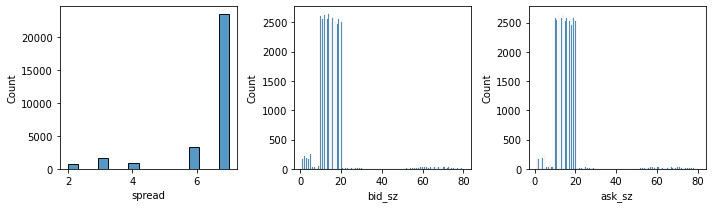

In [10]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['spread','bid_sz','ask_sz']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

BERRIES


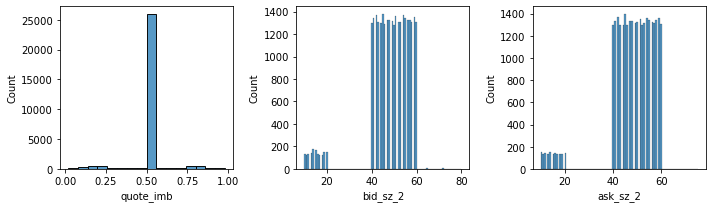

In [11]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['quote_imb','bid_sz_2','ask_sz_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

BERRIES


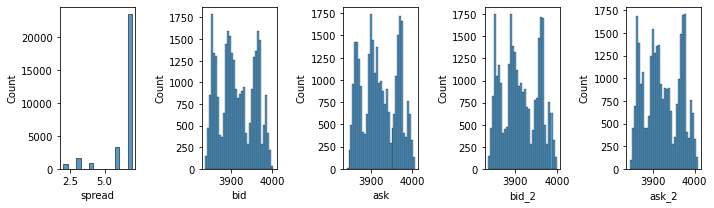

In [12]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['spread','bid','ask', 'bid_2','ask_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

BERRIES


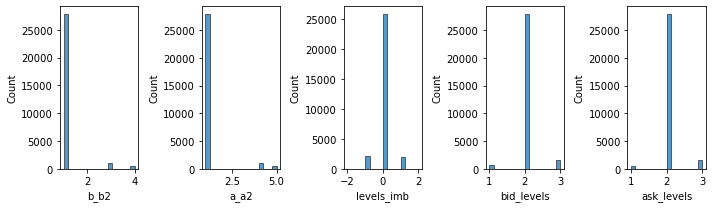

In [13]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    quote['b_b2'] = quote['bid'] - quote['bid_2']
    quote['a_a2'] = quote['ask_2'] - quote['ask']
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['b_b2','a_a2','levels_imb', 'bid_levels', 'ask_levels']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

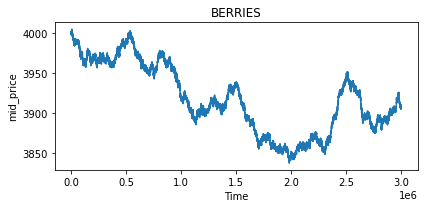

In [14]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    plot_col_sym(quote, sym, 'mid_price')

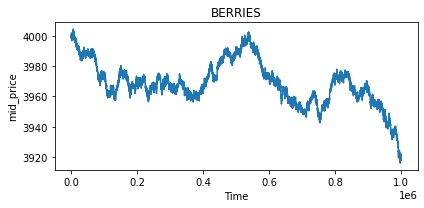

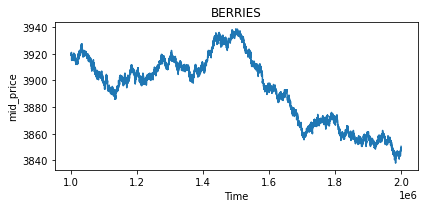

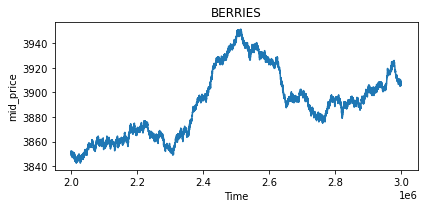

In [299]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    for day in quote['day'].unique():
        plot_col_sym(quote.loc[quote.day == day], sym, 'mid_price')

# Historical Trade Analysis

In [15]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades['quantity'].describe().rename(sym))
print("DATA PER TRADE")
pd.concat(summ,axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
BERRIES,1764.0,8.619048,4.820075,1.0,5.0,9.0,12.0,30.0


In [16]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades.groupby('timestamp')['quantity'].sum().describe().rename(sym))
print("DATA PER STATE")
pd.concat(summ,axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
BERRIES,1727.0,8.803706,4.994229,1.0,5.0,9.0,12.0,31.0


In [179]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym].copy()
    trades = trades.loc[(trades.timestamp >= 350000) & (trades.timestamp <= 750000)]
    summ.append(trades.groupby(['day','timestamp'])['quantity'].sum().describe().rename('state'))
    summ.append(trades['quantity'].describe().rename('trades'))
    
print("DATA PER STATE")
pd.concat(summ,axis=1).transpose()

DATA PER STATE


,count,mean,std,min,25%,50%,75%,max
state,224.0,8.593750,4.712369,1.0,4.75,9.0,12.0,20.0
trades,227.0,8.480176,4.675610,1.0,4.00,9.0,12.0,20.0


BERRIES


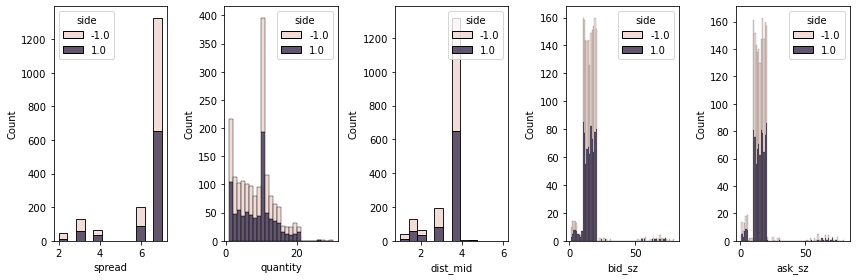

In [17]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['spread'] = trades['ask']-trades['bid']
    trades['dist_mid'] = np.abs(trades['mid_price']-trades['price'])
    
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(12,4))
    for i, col in enumerate(['spread','quantity', 'dist_mid', 'bid_sz','ask_sz']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

BERRIES


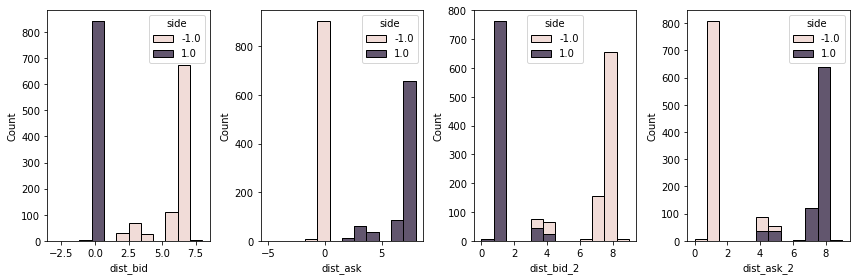

In [18]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['dist_bid'] = trades['price']-trades['bid']
    trades['dist_ask'] = trades['ask']-trades['price']
    
    trades['dist_bid_2'] = trades['price']-trades['bid_2']
    trades['dist_ask_2'] = trades['ask_2']-trades['price']
    
    print(sym)
    f, ax = plt.subplots(1, 4, figsize=(12,4))
    for i, col in enumerate(['dist_bid','dist_ask','dist_bid_2','dist_ask_2']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

# Symbol Specific Correlation Analysis

In [236]:
mid_labels = []
bid_labels = []
ask_labels = []
px_delta_cols = []

for t in FUTURE_TIMES:
    px_delta_cols.append(f'fpx_{t}')
    mid_labels.append(f'fpx_move_{t}')
    bid_labels.append(f'fpx_bid_move_{t}')
    ask_labels.append(f'fpx_ask_move_{t}')

In [237]:
hist_quotes[sym]['time_of_day'] = (hist_quotes[sym]['timestamp']-1000000*hist_quotes[sym]['day'])/100
hist_quotes[sym]['time_to_mid_day'] = 5000 - hist_quotes[sym]['time_of_day']
hist_quotes[sym]['morning'] = np.sign(hist_quotes[sym]['time_to_mid_day'])

In [238]:
quote = hist_quotes[sym]

In [84]:
for sym in SYMBOLS:
    sub_data = hist_quotes[sym].copy()
    sub_data = sub_data.loc[np.abs(sub_data.time_to_mid_day) < 2000]
    print("{} {} {} {:.2f}%".format(sym, len(hist_quotes[sym].copy()), len(sub_data), 100*len(sub_data)/len(quote)))
    corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_v1', 'fair_v1_move_1','time_to_mid_day', 'morning'] + mid_labels + px_delta_cols].corr()
    display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

BERRIES 30000 11997 39.99%


,quote_imb,levels_imb,dist_fair_v1,fair_v1_move_1,time_to_mid_day,morning,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_1,fpx_2,fpx_3,fpx_4,fpx_5,fpx_10,fpx_25,fpx_50
quote_imb,1.000,-0.804,0.687,-0.020,-0.012,-0.011,0.295,0.266,0.249,0.230,0.228,0.183,0.112,0.076,0.402,0.372,0.340,0.311,0.297,0.241,0.149,0.103
levels_imb,-0.804,1.000,-0.908,0.034,0.003,0.005,-0.384,-0.346,-0.324,-0.303,-0.298,-0.242,-0.155,-0.116,-0.526,-0.484,-0.443,-0.414,-0.390,-0.316,-0.205,-0.147
dist_fair_v1,0.687,-0.908,1.000,-0.020,0.002,-0.002,0.398,0.367,0.342,0.322,0.312,0.259,0.168,0.127,0.578,0.527,0.483,0.450,0.421,0.339,0.224,0.161
fair_v1_move_1,-0.020,0.034,-0.020,1.000,0.033,0.042,-0.110,-0.097,-0.079,-0.076,-0.067,-0.059,-0.041,-0.022,-0.097,-0.093,-0.077,-0.077,-0.073,-0.060,-0.039,-0.017
time_to_mid_day,-0.012,0.003,0.002,0.033,1.000,0.866,0.019,0.032,0.040,0.050,0.062,0.095,0.161,0.203,0.019,0.034,0.046,0.057,0.067,0.107,0.186,0.265
morning,-0.011,0.005,-0.002,0.042,0.866,1.000,0.026,0.041,0.054,0.064,0.078,0.119,0.217,0.287,0.024,0.043,0.059,0.073,0.085,0.135,0.237,0.338
fpx_move_1,0.295,-0.384,0.398,-0.110,0.019,0.026,1.000,0.529,0.447,0.401,0.374,0.275,0.186,0.133,0.865,0.518,0.472,0.445,0.415,0.327,0.224,0.159
fpx_move_2,0.266,-0.346,0.367,-0.097,0.032,0.041,0.529,1.000,0.594,0.525,0.482,0.353,0.229,0.163,0.486,0.868,0.580,0.538,0.510,0.404,0.276,0.206
fpx_move_3,0.249,-0.324,0.342,-0.079,0.040,0.054,0.447,0.594,1.000,0.627,0.566,0.408,0.264,0.185,0.422,0.554,0.867,0.611,0.574,0.454,0.307,0.229
fpx_move_4,0.230,-0.303,0.322,-0.076,0.050,0.064,0.401,0.525,0.627,1.000,0.658,0.463,0.299,0.213,0.392,0.503,0.598,0.866,0.643,0.508,0.348,0.259


In [23]:
for sym in SYMBOLS:
    sub_data = hist_quotes[sym].copy()
    # sub_data = sub_data.loc[np.abs(sub_data.dist_fair_v1) > 0.5]
    print("{} {} {} {:.2f}%".format(sym, len(hist_quotes[sym].copy()), len(sub_data), 100*len(sub_data)/len(quote)))
    corr = sub_data[['buy_vol_25', 'sell_vol_25','buy_vol_50', 'sell_vol_50'] + mid_labels].corr()
    display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

BERRIES 30000 30000 100.00%


,buy_vol_25,sell_vol_25,buy_vol_50,sell_vol_50,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50
buy_vol_25,1.000,-0.031,0.695,-0.018,-0.002,-0.001,-0.000,-0.001,-0.001,-0.005,-0.001,-0.023
sell_vol_25,-0.031,1.000,-0.023,0.707,0.001,-0.001,-0.001,-0.001,-0.003,-0.009,-0.021,-0.024
buy_vol_50,0.695,-0.023,1.000,-0.029,-0.003,-0.003,-0.006,-0.008,-0.008,-0.014,-0.030,-0.032
sell_vol_50,-0.018,0.707,-0.029,1.000,-0.004,-0.007,-0.008,-0.011,-0.015,-0.020,-0.025,-0.031
fpx_move_1,-0.002,0.001,-0.003,-0.004,1.000,0.521,0.447,0.404,0.369,0.286,0.188,0.136
fpx_move_2,-0.001,-0.001,-0.003,-0.007,0.521,1.000,0.591,0.527,0.479,0.360,0.232,0.167
fpx_move_3,-0.000,-0.001,-0.006,-0.008,0.447,0.591,1.000,0.634,0.569,0.419,0.269,0.189
fpx_move_4,-0.001,-0.001,-0.008,-0.011,0.404,0.527,0.634,1.000,0.661,0.471,0.304,0.213
fpx_move_5,-0.001,-0.003,-0.008,-0.015,0.369,0.479,0.569,0.661,1.000,0.527,0.333,0.236
fpx_move_10,-0.005,-0.009,-0.014,-0.020,0.286,0.360,0.419,0.471,0.527,1.000,0.471,0.328


In [255]:
quote = hist_quotes[sym].copy()
quote['time'] = (quote['timestamp']-1000000*quote['day'])/100
quote['morning'] = (quote['time'] < 5000) & (quote['time'] > 4000)
quote['afternoon'] = (quote['time'] > 5000) & (quote['time'] < 7000)

horizon = 50

quote['signal'] = quote['dist_fair_v1'] + 0.04*horizon*quote['morning'] + -0.03*horizon*quote['afternoon']
# quote['signal'] = quote['dist_fair_v1'] + 0.04*quote['morning'] + -0.03*quote['afternoon']

In [256]:
sub_data = quote.copy()
total_samples = len(sub_data)
# sub_data = sub_data.loc[sub_data.morning | sub_data.afternoon]
sub_data = sub_data.loc[sub_data.morning | sub_data.afternoon]

analysis_samples = len(sub_data)

print("{} {} {} {:.2f}%".format('BERRIES', analysis_samples, total_samples, 100*analysis_samples/total_samples))
corr = sub_data[['dist_fair_v1', 'signal'] + px_delta_cols].corr()
display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

BERRIES 8994 30000 29.98%


,dist_fair_v1,signal,fpx_1,fpx_2,fpx_3,fpx_4,fpx_5,fpx_10,fpx_25,fpx_50,fpx_75,fpx_100,fpx_200
dist_fair_v1,1.000,0.348,0.580,0.524,0.480,0.447,0.417,0.341,0.222,0.159,0.117,0.106,0.070
signal,0.348,1.000,0.228,0.229,0.232,0.236,0.240,0.267,0.333,0.417,0.471,0.518,0.612
fpx_1,0.580,0.228,1.000,0.554,0.503,0.479,0.441,0.354,0.241,0.177,0.145,0.131,0.092
fpx_2,0.524,0.229,0.554,1.000,0.626,0.583,0.552,0.435,0.302,0.226,0.182,0.167,0.121
fpx_3,0.480,0.232,0.503,0.626,1.000,0.680,0.635,0.511,0.350,0.266,0.214,0.197,0.149
fpx_4,0.447,0.236,0.479,0.583,0.680,1.000,0.720,0.573,0.393,0.302,0.246,0.226,0.171
fpx_5,0.417,0.240,0.441,0.552,0.635,0.720,1.000,0.632,0.430,0.332,0.274,0.251,0.192
fpx_10,0.341,0.267,0.354,0.435,0.511,0.573,0.632,1.000,0.599,0.457,0.384,0.348,0.270
fpx_25,0.222,0.333,0.241,0.302,0.350,0.393,0.430,0.599,1.000,0.711,0.599,0.543,0.424
fpx_50,0.159,0.417,0.177,0.226,0.266,0.302,0.332,0.457,0.711,1.000,0.826,0.740,0.580


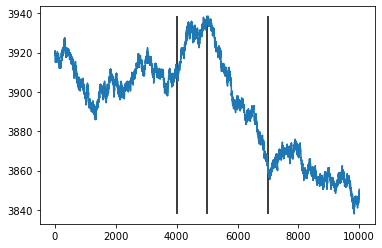

In [148]:
first_day = quote.loc[quote.day == 1]

f, ax = plt.subplots()
ax.plot('time', 'mid_price', data=first_day)
ax.vlines(x=5000, ymin=first_day.mid_price.min(),ymax=first_day.mid_price.max(), color='black')
ax.vlines(x=4000, ymin=first_day.mid_price.min(),ymax=first_day.mid_price.max(), color='black')
# ax.vlines(x=6000, ymin=first_day.mid_price.min(),ymax=first_day.mid_price.max(), color='black')
ax.vlines(x=7000, ymin=first_day.mid_price.min(),ymax=first_day.mid_price.max(), color='black')

# Backtest Analysis

In [8]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})$")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")

    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    observations = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": 0, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            extract_observations(observations, state)
            
    positions = pd.DataFrame(positions)
    observations = pd.DataFrame(observations)
    
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths, observations

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    for p in SYMBOLS:
        if p not in pos:
            positions.append({"timestamp": state['timestamp'], "symbol": p, "position": 0})
    return

def extract_observations(observations, state):
    obs = state['observations']
    for p in obs:
        observations.append({"timestamp": state['timestamp'], "symbol": p, "observation": obs[p]})
        
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return


def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    # trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    # trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    # trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    for col in ['volume', 'notional','trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def combine_quote_algo_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), on=['symbol','timestamp'], how='left', suffixes=('','_algo'))
    
    for col in ['volume_algo', 'notional_algo', 'trades_algo']:
        quote[col].fillna(0, inplace=True)
    
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']
    
def fix_fill_volume(x):
    fill_qty = np.clip(x['fill_qty']-x['quantity'].cumsum()-x['quantity'].iat[0], 0, None)
    return fill_qty

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)

    gcols = ['symbol','timestamp','price','side']
    fill_data = fills.groupby(gcols)[['quantity']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    fill_data['i'] = 0
    orders['i'] = orders.groupby(gcols).cumcount()
    orders = orders.merge(fill_data, how='left', on=gcols+['i']).drop('i',axis=1)
    orders['fill_qty'].fillna(0, inplace=True)    
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders

# PnL, Position, Volume Traded, Notional Traded, VWAP
def trading_performance(positions, own_trades, quote):
    positions = positions.merge(quote[['timestamp','symbol','mid_price']], on=['symbol','timestamp']) # Add mid price
    own_trades['trades'] = 1
    own_trades['notional'] = own_trades['price']*own_trades['quantity']
    own_trades.rename(columns={'quantity':'qty'},inplace=True)
    vol_cols = []
    for col in ['qty','notional','trades']:
        own_trades[f'buy_{col}'] = own_trades[col]
        own_trades[f'sell_{col}'] = own_trades[col]
        own_trades.loc[own_trades['side'] == -1, f'buy_{col}'] = 0
        own_trades.loc[own_trades['side'] == 1, f'sell_{col}'] = 0
        vol_cols += [col, f'buy_{col}',f'sell_{col}']
    own_trades_g = own_trades.groupby(['symbol','timestamp'])[vol_cols].sum()

    positions = positions.merge(own_trades_g.reset_index(), how='left', on=['symbol','timestamp'])
    for col in vol_cols:
        positions[col].fillna(0, inplace=True)
        positions[f'total_{col}'] = positions.groupby('symbol')[col].transform(pd.Series.cumsum)
    positions['pnl'] = (positions['total_sell_notional']-positions['total_buy_notional']) \
            - positions['mid_price']*(positions['total_sell_qty']-positions['total_buy_qty'])

    positions = positions.copy()
    return positions

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths, observations = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    
    quote = combine_quote_trades(quote, market_trades.copy())
    quote = combine_quote_algo_trades(quote, own_trades.copy())

    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    order_depths = combine_quote_algo_trades(order_depths, own_trades.copy())
    
    positions = trading_performance(positions, own_trades.copy(), quote) 
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['order_depths'] = order_depths
    dfs['quote'] = quote
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    dfs['observations'] = observations
    
    if by_symbol:
        for table in dfs:
            if not dfs[table].empty:
                dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

In [9]:
def plot_intraday(dfs, col):
    f, ax = plt.subplots(figsize=fig_size)
    for product in dfs:
        ax.plot("timestamp", col, data=dfs[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.legend()
    plt.tight_layout()
    
    return

def trading_simulation_summary(dfs):
    total_pnl = 0
    for sym in SYMBOLS:
        trade_perf = dfs['positions'][sym].iloc[-1]
        pnl = trade_perf['pnl']
        total_pnl += pnl
        market_volume = dfs['market_trades'][sym]['quantity'].sum()
        trade_count = trade_perf['total_trades']
        trade_volume = trade_perf['total_qty']
        vol_per_step = dfs['positions'][sym]['qty'].mean()

        print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | Shares/Step={:.3} | PnL/Share={:.4}""".format(sym, \
            pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), vol_per_step, pnl/trade_volume))
    print("Total PnL={}".format(total_pnl))
    plot_intraday(dfs['positions'], 'pnl')
    plot_intraday(dfs['positions'], 'position')

In [10]:
def algo_spread(x):
    bid = np.fmax(x['price_algo_buy'], x['bid'])
    ask = np.fmin(x['price_algo_sell'], x['ask'])
    return ask-bid

algo_market_cols = ['symbol', 'timestamp', 'price_algo_buy', 'price_algo_sell','algo_spread']
def get_algo_market(orders, quote):
    buy_orders = orders.loc[orders.side == 1].copy()
    sell_orders = orders.loc[orders.side == -1].copy()

    buy_spread = buy_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    buy_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='last') # keep most aggressive
    sell_spread = sell_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    sell_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='first')
    
    algo_market = buy_spread.merge(sell_spread, how='outer', on=['symbol','timestamp'], suffixes=['_algo_buy','_algo_sell'])
    algo_market.sort_values('timestamp',inplace=True)
    algo_market = algo_market.merge(quote, how='left', on=['symbol','timestamp'])
    algo_market['spread'] = algo_market['ask'] - algo_market['bid']
    algo_market['algo_spread'] = algo_market.apply(algo_spread, axis=1)
    
    return algo_market

def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    orders['filled'] = orders['fill_qty'] > 0
    
    for t in FUTURE_TIMES:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

toxicity_labels, reversion_labels = [], []
for t in FUTURE_TIMES:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')

def get_orders_fills(market_trades, orders, quote):
    algo_market = get_algo_market(orders, quote)

    orders_cols = ['note', 'price', 'quantity', 'side', 'symbol', 'timestamp','fill_qty']
    fills = orders.loc[orders.fill_qty > 0]
    fills = fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    order_analysis(fills)
    fills = fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])

    missed_fills = orders[orders_cols].merge(market_trades, on=['symbol','timestamp'], suffixes=('_algo','_mkt'))
    missed_fills = missed_fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    missed_fills = missed_fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])
    
    return fills, missed_fills

## Load

In [328]:
SYMBOLS = ['BANANAS','PEARLS']

BERRIES: PnL=13832.0 | Trades=1183.0 | MarketVol=5046 | Volume Filled=9298.0 | POV=0.65 | Shares/Step=0.93 | PnL/Share=1.488
Total PnL=13832.0


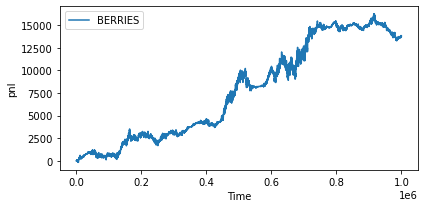

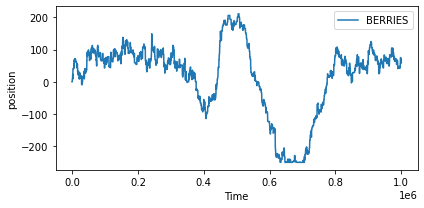

In [11]:
log_file = "backtest_logs/backtest.log"

dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

## Trades

In [263]:
sym = 'BERRIES'
market_trades = dfs['market_trades'][sym]
orders = dfs['orders'][sym]
quote = dfs['order_depths'][sym].copy()
fills, missed_fills = get_orders_fills(market_trades, orders, quote)

In [269]:
fills['time'] = fills['timestamp']/100
fills['morning'] = (fills['time'] < 5000) & (fills['time'] > 4000)
fills['afternoon'] = (fills['time'] > 5000) & (fills['time'] < 7000)

missed_fills['time'] = missed_fills['timestamp']/100
missed_fills['morning'] = (missed_fills['time'] < 5000) & (missed_fills['time'] > 4000)
missed_fills['afternoon'] = (missed_fills['time'] > 5000) & (missed_fills['time'] < 7000)

In [265]:
fills.groupby(['side','note'])[['pnl_1','pnl_5','pnl_10','pnl_25','pnl_50','fill_qty']].sum()

pnl_1   pnl_5  pnl_10  pnl_25  pnl_50  fill_qty
side note                                                  
-1   P0      -7.5    -2.5   -12.5     7.5    17.5       5.0
     P1     276.5   308.0   457.0   544.0   473.5     116.0
     P2    3385.5  3400.0  3065.0  2981.0  2853.0    1463.0
     P3    2118.0  2076.0  2053.0  1823.5  2411.5     858.0
     P4     138.5   120.5   104.0   144.5   165.5      51.0
     X_0    -24.5   300.5    90.5  -317.0  -826.0    2768.0
 1   P0     238.0   218.0   164.5   249.0   283.0      94.0
     P1    2062.0  2176.0  2248.5  2017.5  1967.5     984.0
     P2    2841.5  2646.5  2782.0  3613.0  4006.0    1104.0
     P3     290.5   264.0   216.5   196.0    72.5     102.0
     X_0   2331.5  2859.0  2836.5  3328.0  4430.0    3062.0

In [273]:
fills.groupby(['side','morning','afternoon','note'])[['pnl_1','pnl_5','pnl_10','pnl_25','pnl_50','fill_qty']].sum()

pnl_1   pnl_5  pnl_10  pnl_25  pnl_50  fill_qty
side morning afternoon note                                                  
-1   False   False     P1     224.0   237.5   386.5   476.5   454.0      95.0
                       P2    2311.0  2331.0  2056.0  2152.0  1935.0    1004.0
                       P3    1515.0  1485.5  1560.0  1274.0  1476.0     605.0
                       X_0   -100.5   105.5   -14.0  -408.0  -658.0    1970.0
             True      P0      -7.5    -2.5   -12.5     7.5    17.5       5.0
                       P2     593.5   563.5   656.5   719.0   805.0     248.0
                       P3     480.5   502.0   469.5   595.0  1042.0     208.0
                       P4     117.5   102.5    95.0   150.5   186.5      45.0
                       X_0     95.0   255.5   178.0   371.5   388.5     611.0
     True    False     P1      52.5    70.5    70.5    67.5    19.5      21.0
                       P2     481.0   505.5   352.5   110.0   113.0     211.0
                       P3     122.5    88.5    23.5   -45.5  -106.5      45.0
                       P4      21.0    18.0     9.0    -6.0   -21.0       6.0
                       X_0    -19.0   -60.5   -73.5  -280.5  -556.5     187.0
 1   False   False     P0      35.0    77.0    63.0    70.0   119.0      14.0
                       P1    1572.0  1701.0  1701.5  1579.0  1807.0     735.0
                       P2    1970.0  1876.5  1934.0  2522.0  2430.0     754.0
                       P3     139.0   122.5   121.5    93.5    76.5      53.0
                       X_0   1842.0  2229.5  2121.0  2398.0  3327.5    2359.0
             True      P0     136.5   105.5   116.0    81.5   -35.5      49.0
                       P1     430.0   396.5   449.5   322.0   -32.0     212.0
                       P2     459.5   323.5   364.0   532.5   601.5     190.0
                       P3      15.0    25.0    25.0    15.0     5.0      10.0
                       X_0    249.0   379.0   384.0   288.5   -31.0     380.0
     True    False     P0      66.5    35.5   -14.5    97.5   199.5      31.0
                       P1      60.0    78.5    97.5   116.5   192.5      37.0
                       P2     412.0   446.5   484.0   558.5   974.5     160.0
                       P3     136.5   116.5    70.0    87.5    -9.0      39.0
                       X_0    240.5   250.5   331.5   641.5  1133.5     323.0

In [270]:
missed_fills.groupby(['side_algo','morning','afternoon'])['note'].value_counts()

side_algo  morning  afternoon  note
-1         False    False      P2      255
                               P3      127
                               P1       18
                               X_0      14
                               P0        3
                    True       P3       47
                               P2       45
                               P4       13
                               P1        4
                               X_0       3
                               P0        1
           True     False      P2       50
                               P1        5
                               P3        5
                               P4        4
                               P0        1
 1         False    False      P1      199
                               P2      179
                               X_0      21
                               P0       13
                               P3       12
                    True       P1       55
                  